In [4]:
import numpy as np
import matplotlib.pyplot as plt

# import EPG class
# if available import fast pyepg, otherwise use basic_epg
import importlib.util
pyepg_spec  = importlib.util.find_spec("pyepg")
pyepg_found = pyepg_spec is not None

if pyepg_found:
    import pyepg
else:
    from epg_code import basic_epg
    print('module pyepg not found ... continue with slower basic_epg module')


In [5]:
# compute and return all EPG states (F,Z) for N RF pulses with flip-angle FA and phase PHI 
def epg_states(M0,T1,T2,TR,FA,PHI,N,RFSpoil=False,after_pulse=True):
    F=np.zeros((2*N+1,N),dtype=complex)
    Z=np.zeros((N,N),dtype=complex)
    # use basic_epg class if pyepg is not available
    EPG = basic_epg(M0, T1, T2, TR) if not pyepg_found else pyepg.PyEPG(M0, T1, T2, TR)

    for n in range(N):
        EPG.Step(FA,  PHI, RFSpoil=RFSpoil)
        for k in range(n+1):
            if after_pulse: # magnetization after last pulse
                Z[k,n]     = EPG.GetReZa(k) +1j*EPG.GetImZa(k)
                F[N+k,n]   = EPG.GetReFa(k) +1j*EPG.GetImFa(k)
                F[N-k,n]   = EPG.GetReFa(-k)+1j*EPG.GetImFa(-k)
            else:          # magnetization before next pulse
                Z[k,n]     = EPG.GetReZb(k) +1j*EPG.GetImZb(k)
                F[N+k+1,n] = EPG.GetReFb(k+1) +1j*EPG.GetImFb(k+1)
                F[N-k+1,n] = EPG.GetReFb(-k+1)+1j*EPG.GetImFb(-k+1)
    return (F,Z)

# plot EPG states with matplotlib.pyplot.imshow()
def plot_states(ax,S,N,step_n=1,step_k=1,aspect=0.8,vmax=0.5,yticks=True,title=''):
    dim=np.shape(S)
    if dim[0]==dim[1]:  # Z states
        im = ax.imshow(np.flipud(np.abs(S)),extent=[1,N+1,0,N],aspect=aspect,vmax=vmax)
        yrange=np.arange(.5,N+.5,step_k)
        ax.set_yticks(yrange)
        ax.set_yticklabels(yrange.astype(int))
    else:               # F states
        im = ax.imshow(np.flipud(np.abs(S)),extent=[1,N+1,-N-.5,N+.5],aspect=aspect,vmax=vmax)
        yrange=range(-N,N+1,step_k)
        ax.set_yticks(yrange)

    ax.set_xticks(range(1,N+1,step_n))
    ax.set_xlabel('pulse number n')

    if yticks:
        ax.set_ylabel('state number k')

    if title != '':
        ax.set_title(title)
    return im



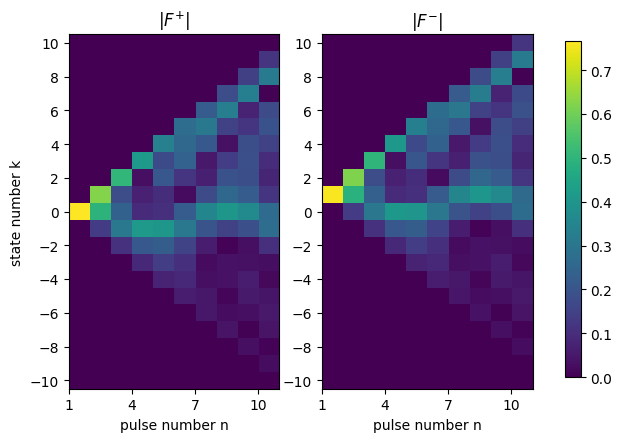

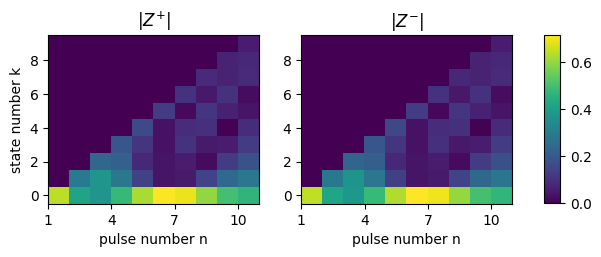

In [6]:
M0 = 1
T1 = 1000
T2 = 1000
TR = 10.0
FA = 50
PH = 117
N  = 10
RFSpoil = False

(Fa,Za) = epg_states(M0,T1,T2,TR,FA,PH,N,RFSpoil=RFSpoil,after_pulse=True)  # states after RF pulses
(Fb,Zb) = epg_states(M0,T1,T2,TR,FA,PH,N,RFSpoil=RFSpoil,after_pulse=False) # states before RF pulses

#plot F-states
fig1, (ax1, ax2) = plt.subplots(1, 2)
max = np.max(np.abs((Fa,Fb)))
im1 = plot_states(ax1,Fa,N,step_n=N//3,step_k=N//4,title='$|F^{+}|$',vmax=max)
im2 = plot_states(ax2,Fb,N,step_n=N//3,step_k=N//4,yticks=False,title='$|F^{-}|$',vmax=max)
fig1.subplots_adjust(right=0.85)
cba = fig1.add_axes([0.9, 0.15, 0.025, 0.7])
fig1.colorbar(im1,cba)
plt.show()

#plot Z-states
fig2, (ax1, ax2) = plt.subplots(1, 2)
max = np.max(np.abs((Za,Zb)))
im1=plot_states(ax1,Za,N,step_n=N//3,step_k=N//4,title='$|Z^{+}|$',vmax=max)
im2=plot_states(ax2,Zb,N,step_n=N//3,step_k=N//4,yticks=False,title='$|Z^{-}|$',vmax=max)
fig2.subplots_adjust(right=0.85)
cba = fig2.add_axes([0.9, 0.32, 0.025, 0.35])
fig2.colorbar(im1,cba)
plt.show()

